In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics,preprocessing,svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from pydotplus import graph_from_dot_data
from IPython.display import Image
from keras import layers, models
from keras.optimizer_v2 import adam
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text
from keras.utils import vis_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
%matplotlib inline

dataset citation:
https://research.aalto.fi/en/datasets/phishstorm-phishing-legitimate-url-dataset
"
Description
URLs dataset with features built and used for evaluation in the paper "PhishStorm: Detecting Phishing with Streaming Analytics" published in IEEE TNSM.
The dataset contains 96,018 URLs: 48,009 legitimate URLs and 48,009 phishing URLs.

This is a CSV file where the "domain" column provides a unique identifier for each entry (which is actually a URL). The "label" column provides the domain entry status, 0: legitimate / 1:phishing.
Other columns provide computed values for features introduced in [1].

Please refer to the following publication when citing this dataset:
[1] S. Marchal, J. Francois, R. State, and T. Engel. PhishStorm: Detecting Phishing with Streaming Analytics. IEEE Transactions on Network and Service Management (TNSM), 11(4):458-471, 2014.
"

In [2]:
seed = 69 # fix random seed
df = pd.read_csv('urlset.csv',
                 encoding='UTF-8',
                 encoding_errors='ignore',
                 on_bad_lines='skip',
                 low_memory=False)

In [3]:
df.head(5)

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11.0,150.636364,152.272727,0.0,0.0,0.0,0.0,0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14.0,73.500000,72.642857,0.0,0.0,0.0,0.0,0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6.0,562.000000,590.666667,0.0,0.0,0.0,0.0,0,0.85964,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8.0,29.000000,24.125000,0.0,0.0,0.0,0.0,0,0.748971,1.0


In [4]:
df.shape

(96003, 14)

### there are some unreadable row, we have to skip therefore the dataset contains total 96003 samples. However, there is two duplicates values, we have to drop them. Therefore, the dataset contains total 96001 samples

In [5]:
# remove other unneccessary columns, only keep url and label and make sure url type is string
df = df[['domain','label']].astype({'domain':str,'label':float})
df = df.drop_duplicates(ignore_index=False)

In [6]:
df.head(5)

,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


In [7]:
all_char = list(''.join(df.domain.values.tolist()))
unique_char = np.unique(all_char,return_counts=True)
print("Raw data total {} unique characters:".format(unique_char[0].shape[0]))
print(unique_char[0])

Raw data total 402 unique characters:
['\x01' '\x02' '\x03' '\x04' '\x05' '\x06' '\x07' '\x08' '\t' '\n' '\x0b'
 '\x0c' '\r' '\x0e' '\x0f' '\x10' '\x11' '\x12' '\x13' '\x14' '\x15'
 '\x16' '\x17' '\x18' '\x19' '\x1a' '\x1b' '\x1c' '\x1d' '\x1e' '\x1f' ' '
 '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2'
 '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' 'A' 'B' 'C' 'D'
 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V'
 'W' 'X' 'Y' 'Z' '[' '\\' ']' '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'
 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z'
 '{' '|' '}' '~' '\x7f' '\x87' '\x8d' '\x8f' '\x92' '¥' '\xad' '¸' 'Æ' 'Ç'
 'Î' 'Ò' 'Ó' '×' 'Û' 'à' 'ñ' 'ā' 'ą' 'Č' 'č' 'ģ' 'ī' 'į' 'Ĳ' 'Ŀ' 'ń' 'ň'
 'Ŧ' 'ũ' 'Ū' 'ů' 'Ż' 'ſ' 'ƃ' 'Ƈ' 'Ɖ' 'Ɗ' 'ƭ' 'ư' 'Ʊ' 'ǆ' 'Ǔ' 'Ǡ' 'ǡ' 'Ǥ'
 'Ǭ' 'ǽ' 'ȅ' 'ȍ' 'Ȕ' 'Ș' 'Ȳ' 'Ⱦ' 'Ɍ' 'ɒ' 'ɔ' 'ɦ' 'ɧ' 'ɮ' 'ʃ' 'ʋ' 'ʒ' 'ʖ'
 'ʟ' 'ʡ' 'ʩ' 'ʭ' 'ʴ' 'ʸ' 'ˊ' 'ˎ' '˗' '˛' '˞' '˟' 'ˠ' '˨' '˱' '́' '̅' '̈'
 '̉' '̍' '̜

##### preprocessing data
1. fit character into numerical values
2. only keep the url length up to 75 characters
3. if url does not have 75 characters then padding in front with 0
4. remove all $\pm\infty$ and nan values
5. balance binary dataset

In [8]:
char_tok = text.Tokenizer(char_level=True) # character function
char_tok.fit_on_texts(df.domain) # fit character
data = char_tok.texts_to_sequences(df.domain)
num_char = len(char_tok.word_index)+1
max_length = max([len(n) for n in data])
length = 75
epochs = 10
batch_size = 100
print("The longest URL length:{}".format(max_length)) # check maximum possible length
print('='*80)
data = sequence.pad_sequences(data,maxlen=length,dtype=np.float64) 
print("Total {} samples and only use {} features".format(*data.shape))
print('='*80)
# save data and its target to a new dataframe
data = pd.DataFrame(np.hstack((data,df[['label']].values)))
# drop nan, inf, or -inf values
data = data.replace([np.inf, -np.inf], np.nan).dropna()
columns = data.columns
rus = RandomUnderSampler(random_state=seed) # random balance smaple function
standard = preprocessing.StandardScaler() # standardize data function
X, y = rus.fit_resample(data[columns[:-1]],data[columns[-1]])
print("After balance sampling:")
print(f"|phishing:  {len(y[y==1])}  | non-phishing: {len(y[y==0])}")
print('='*80)
# split dataset for training, validation and testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=y)
print("split dataset into training and testing:")
print(f"Training size: {y_train.shape[0]}; Testing size: {y_test.shape[0]}")
print('='*80)

The longest URL length:2175
Total 96001 samples and only use 75 features
After balance sampling:
|phishing:  47902  | non-phishing: 47902
split dataset into training and testing:
Training size: 76643; Testing size: 19161


In [9]:
def CNN_model(num_char=373,length=75):
    '''
    convolutional neural network
    '''
    model = models.Sequential([Embedding(num_char,128,input_length=length), # embedding
                               layers.Dropout(0.5), 
                               layers.Conv1D(256, 3), # conv layer 1
                               layers.ELU(), # Exponential Linear Unit
                               layers.BatchNormalization(), # batach normalization 
                               layers.Dropout(0.5),
                               layers.Conv1D(512, 6), # conv layer 2
                               layers.ELU(), # Exponential Linear Unit
                               layers.BatchNormalization(), # batach normalization 
                               layers.Dropout(0.5),
                               layers.Conv1D(1024,8), # conv layer 3
                               layers.ELU(), # Exponential Linear Unit
                               layers.BatchNormalization(), # batach normalization 
                               layers.Dropout(0.5),
                               layers.Flatten(),
                               layers.Dense(1024,activation='relu'), # hidden layer 1
                               layers.BatchNormalization(), # batach normalization 
                               layers.Dropout(0.5),
                               layers.Dense(256, activation='relu'), # hidden layer 2
                               layers.BatchNormalization(), # batach normalization 
                               layers.Dropout(0.5),
                               layers.Dense(64,  activation='relu'), # hidden layer 3
                               layers.BatchNormalization(), # batach normalization 
                               layers.Dropout(0.5),
                               layers.Dense(1,activation='sigmoid')]) # output layer
    model_compile(model)
    return model

def LSTM_model(num_char=373,length=75):
    '''
    model with one embedding layer,
    follow up with 25% drop out and batach normalization
    lstm layer with 128 units and 50% recurrent drop out
    '''
    model =models.Sequential([Embedding(num_char,128,input_length=length), # embedding
                              layers.Dropout(0.25),
                              layers.BatchNormalization(), # batach normalization 
                              layers.LSTM(128,recurrent_dropout=0.5), # long-short term memory
                              layers.Dropout(0.5),
                              layers.Flatten(),
                              layers.Dense(1,activation='sigmoid')]) # output layer
    model_compile(model)
    return model

def LSTM_larger_model(num_char=373,length=75):
    '''
    model with one embedding layer,
    follow up with 25% drop out and batach normalization
    lstm layer with 256 units and 50% recurrent drop out
    lstm layer with 512 units and 50% recurrent drop out
    '''
    model =models.Sequential([Embedding(num_char,128,input_length=length), # embedding
                              layers.Dropout(0.25),
                              layers.BatchNormalization(), # batach normalization 
                              layers.LSTM(256,recurrent_dropout=0.5,
                                          return_sequences=True,
                                          input_shape=(75,128)), # long-short term memory
                              layers.Dropout(0.5),
                              layers.BatchNormalization(), # batach normalization
                              layers.LSTM(512,recurrent_dropout=0.5), # long-short term memory
                              layers.Dropout(0.5),
                              layers.Flatten(),
                              layers.Dense(1,activation='sigmoid')]) # output layer
    model_compile(model)
    return model
    

def model_compile(model):
    '''
    model compile with binary corss entropy, adam optimizer with learning rate 0.005
    '''
    model.compile(loss='binary_crossentropy',
                  optimizer=adam.Adam(learning_rate=0.005),
                  metrics=['accuracy'])

def train_model(model,X_train,y_train,epochs=10,batch_size=32,filename='cnn'):
#     print("model summary")
#     print(model.summary())
    print(f"training model with {epochs} epochs and batches of size {batch_size}:")
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(filename+'.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,
                                       verbose=1,min_delta=1e-4, mode='min')
    return model.fit(X_train,y_train,validation_split=0.2,epochs=epochs,
                     batch_size=batch_size,use_multiprocessing=True,
                     callbacks=[earlyStopping, mcp_save,reduce_lr_loss])

def load_best_model(model,filename='cnn'):
    return model.load_weights(filepath = filename+'.hdf5')


def evaluate_model(model,X_test,y_test):
    print("model summary")
    print(model.summary())
    print(f"testing model:")
    result = model.evaluate(X_test,y_test)
    print("Model score: {:.04f} and accuracy: {:0.2f}%".format(result[0],result[1]*100))
    
def classification_report(model,X_test,y_test):
    print("claissification report:")
    print(metrics.classification_report(y_test,
                                  np.where(model.predict(X_test,
                                                         use_multiprocessing=True)>0.5,
                                           1,0)))
    
def export_plot(model,fname='cnn'):
    '''
    plot modell's structure
    '''
    vis_utils.plot_model(model,to_file=fname+'.png',show_shapes=True,
                         show_layer_names=True,expand_nested=True,dpi=96,)
    
def plot_acc(ax,hist,title):
    val = title if title == 'Accuracy' else 'Loss'
    ax.plot(hist.history[val.lower()],lw=2)
    ax.plot(hist.history['val_'+val.lower()],lw=2)
    ax.set(title=title,ylabel=val,xlabel='Epoch')
    ax.legend(['Train','Test'],fontsize='xx-large')
    ax.grid(True)

def false_negative_rate(cm):
    '''
    compute false negative rate
    '''
    tn, fp, fn, tp = cm.ravel()
    return fn/(fn+tp)

In [10]:
cnn_model = CNN_model(num_char,length)
export_plot(cnn_model,'cnn')

2021-12-02 16:31:10.505902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
cnn_hist = train_model(cnn_model,X_train,y_train,filename='cnn')

training model with 10 epochs and batches of size 32:
Epoch 1/10
1917/1917 [==============================] - 2552s 1s/step - loss: 0.3437 - accuracy: 0.8549 - val_loss: 0.2116 - val_accuracy: 0.9189 - lr: 0.0050
Epoch 2/10
1917/1917 [==============================] - 2498s 1s/step - loss: 0.2269 - accuracy: 0.9112 - val_loss: 0.1654 - val_accuracy: 0.9354 - lr: 0.0050
Epoch 3/10
1917/1917 [==============================] - 2509s 1s/step - loss: 0.1885 - accuracy: 0.9289 - val_loss: 0.1713 - val_accuracy: 0.9384 - lr: 0.0050
Epoch 4/10
1917/1917 [==============================] - 2863s 1s/step - loss: 0.1677 - accuracy: 0.9369 - val_loss: 0.1299 - val_accuracy: 0.9487 - lr: 0.0050
Epoch 5/10
1917/1917 [==============================] - 2946s 2s/step - loss: 0.1615 - accuracy: 0.9396 - val_loss: 0.1144 - val_accuracy: 0.9554 - lr: 0.0050
Epoch 6/10
1917/1917 [==============================] - 2753s 1s/step - loss: 0.1423 - accuracy: 0.9472 - val_loss: 0.1116 - val_accuracy: 0.9636 - lr:

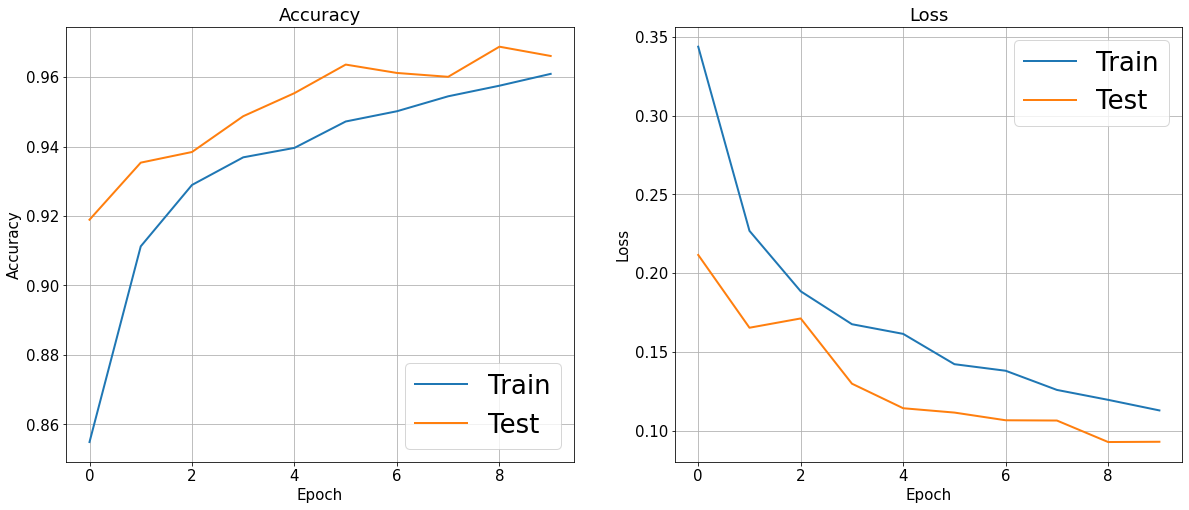

In [12]:
load_best_model(cnn_model,filename='cnn')
plt.rcParams.update({'font.size':15})
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
ax = ax.flatten()
plot_acc(ax[0],cnn_hist,'Accuracy')
plot_acc(ax[1],cnn_hist,'Loss')

In [13]:
evaluate_model(cnn_model,X_test,y_test)

model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 128)           47744     
                                                                 
 dropout (Dropout)           (None, 75, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 73, 256)           98560     
                                                                 
 elu (ELU)                   (None, 73, 256)           0         
                                                                 
 batch_normalization (BatchN  (None, 73, 256)          1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 73, 256)           0         
                                          

false negative rate: 4.1754%


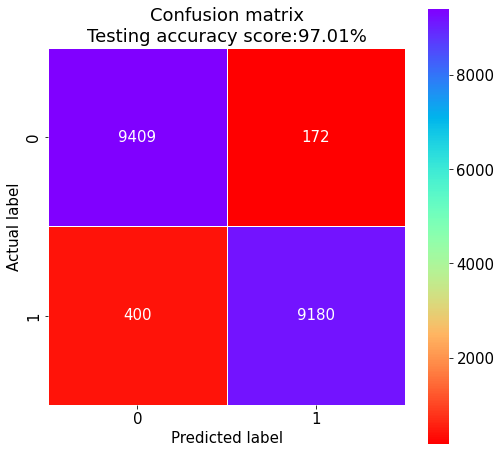

In [14]:
plt.rcParams.update({'font.size':15})
ax = plt.figure(figsize=(8,8))
y_pred = np.where(cnn_model.predict(X_test,use_multiprocessing=True)>0.5,1,0)
cm = metrics.confusion_matrix(y_test,y_pred)
print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
print('='*80)
sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nTesting accuracy score:'
          '{:0.2f}%'.format(metrics.accuracy_score(y_test,y_pred)*100),size=18)
plt.show()

In [15]:
classification_report(cnn_model,X_test,y_test)

claissification report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9581
         1.0       0.98      0.96      0.97      9580

    accuracy                           0.97     19161
   macro avg       0.97      0.97      0.97     19161
weighted avg       0.97      0.97      0.97     19161



In [16]:
lstm_model = LSTM_model(num_char,length)
export_plot(lstm_model,'lstm')

In [17]:
lstm_hist = train_model(lstm_model,X_train,y_train,filename='lstm1')

training model with 10 epochs and batches of size 32:
Epoch 1/10
1917/1917 [==============================] - 264s 137ms/step - loss: 0.2800 - accuracy: 0.8885 - val_loss: 0.2051 - val_accuracy: 0.9224 - lr: 0.0050
Epoch 2/10
1917/1917 [==============================] - 258s 135ms/step - loss: 0.2573 - accuracy: 0.8991 - val_loss: 0.2288 - val_accuracy: 0.9117 - lr: 0.0050
Epoch 3/10
1917/1917 [==============================] - 263s 137ms/step - loss: 0.3388 - accuracy: 0.8598 - val_loss: 0.3102 - val_accuracy: 0.8646 - lr: 0.0050
Epoch 4/10
1917/1917 [==============================] - 258s 134ms/step - loss: 0.3450 - accuracy: 0.8555 - val_loss: 0.2964 - val_accuracy: 0.8830 - lr: 0.0050
Epoch 5/10
1917/1917 [==============================] - 286s 149ms/step - loss: 0.4043 - accuracy: 0.8224 - val_loss: 0.3518 - val_accuracy: 0.8537 - lr: 0.0050
Epoch 6/10
1917/1917 [==============================] - 270s 141ms/step - loss: 0.4020 - accuracy: 0.8215 - val_loss: 0.3345 - val_accuracy: 

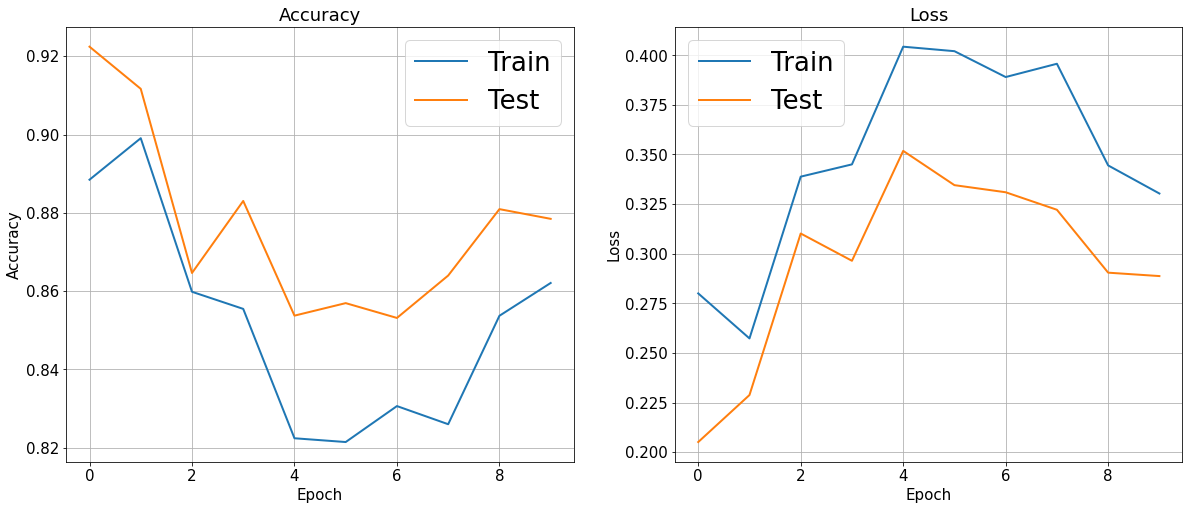

In [18]:
load_best_model(lstm_model,filename='lstm1')
plt.rcParams.update({'font.size':15})
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
ax = ax.flatten()
plot_acc(ax[0],lstm_hist,'Accuracy')
plot_acc(ax[1],lstm_hist,'Loss')

In [19]:
evaluate_model(lstm_model,X_test,y_test)

model summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 75, 128)           47744     
                                                                 
 dropout_7 (Dropout)         (None, 75, 128)           0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                        

false negative rate: 8.4760%


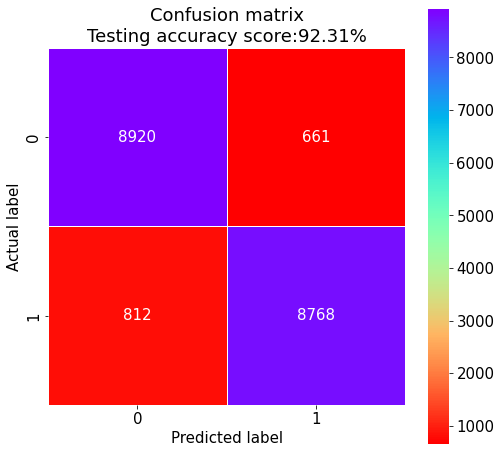

In [20]:
plt.rcParams.update({'font.size':15})
ax = plt.figure(figsize=(8,8))
y_pred = np.where(lstm_model.predict(X_test,use_multiprocessing=True)>0.5,1,0)
cm = metrics.confusion_matrix(y_test,y_pred)
print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
print('='*80)
sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nTesting accuracy score:'
          '{:0.2f}%'.format(metrics.accuracy_score(y_test,y_pred)*100),size=18)
plt.show()

In [21]:
classification_report(lstm_model,X_test,y_test)

claissification report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      9581
         1.0       0.93      0.92      0.92      9580

    accuracy                           0.92     19161
   macro avg       0.92      0.92      0.92     19161
weighted avg       0.92      0.92      0.92     19161



In [22]:
larger_lstm = LSTM_larger_model(num_char,length)
export_plot(larger_lstm,'larger_lstm')

In [23]:
larger_lstm_hist = train_model(larger_lstm,X_train,y_train,filename='lstm2')

training model with 10 epochs and batches of size 32:
Epoch 1/10
1917/1917 [==============================] - 3705s 2s/step - loss: 0.3149 - accuracy: 0.8719 - val_loss: 0.2494 - val_accuracy: 0.8976 - lr: 0.0050
Epoch 2/10
1917/1917 [==============================] - 3659s 2s/step - loss: 0.4706 - accuracy: 0.7797 - val_loss: 0.4086 - val_accuracy: 0.8208 - lr: 0.0050
Epoch 3/10
1917/1917 [==============================] - 3687s 2s/step - loss: 0.5150 - accuracy: 0.7534 - val_loss: 0.4420 - val_accuracy: 0.8021 - lr: 0.0050
Epoch 4/10
1917/1917 [==============================] - 3723s 2s/step - loss: 0.4646 - accuracy: 0.7835 - val_loss: 0.3978 - val_accuracy: 0.8184 - lr: 0.0050
Epoch 5/10
1917/1917 [==============================] - 3666s 2s/step - loss: 0.4488 - accuracy: 0.7943 - val_loss: 0.4193 - val_accuracy: 0.8100 - lr: 0.0050
Epoch 6/10
1917/1917 [==============================] - 3635s 2s/step - loss: 0.4351 - accuracy: 0.8046 - val_loss: 0.3782 - val_accuracy: 0.8304 - lr:

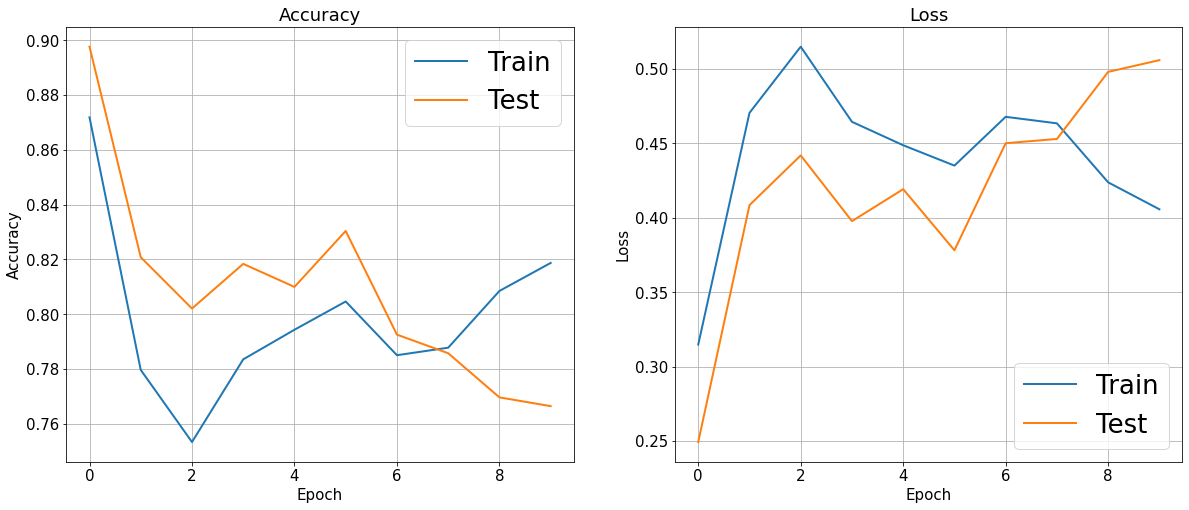

In [24]:
load_best_model(larger_lstm,filename='lstm2')
plt.rcParams.update({'font.size':15})
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
ax = ax.flatten()
plot_acc(ax[0],larger_lstm_hist,'Accuracy')
plot_acc(ax[1],larger_lstm_hist,'Loss')

In [25]:
evaluate_model(larger_lstm,X_test,y_test)

model summary
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 75, 128)           47744     
                                                                 
 dropout_9 (Dropout)         (None, 75, 128)           0         
                                                                 
 batch_normalization_7 (Batc  (None, 75, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 75, 256)           394240    
                                                                 
 dropout_10 (Dropout)        (None, 75, 256)           0         
                                                                 
 batch_normalization_8 (Batc  (None, 75, 256)          1024      
 hNormalization)                        

false negative rate: 14.0605%


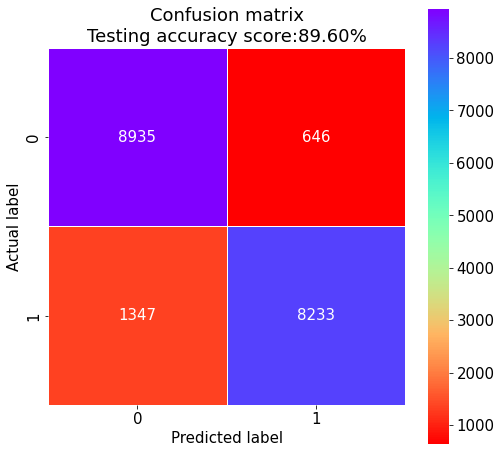

In [26]:
plt.rcParams.update({'font.size':15})
ax = plt.figure(figsize=(8,8))
y_pred = np.where(larger_lstm.predict(X_test,use_multiprocessing=True)>0.5,1,0)
cm = metrics.confusion_matrix(y_test,y_pred)
print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
print('='*80)
sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nTesting accuracy score:'
          '{:0.2f}%'.format(metrics.accuracy_score(y_test,y_pred)*100),size=18)
plt.show()

In [27]:
classification_report(larger_lstm,X_test,y_test)

claissification report:
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      9581
         1.0       0.93      0.86      0.89      9580

    accuracy                           0.90     19161
   macro avg       0.90      0.90      0.90     19161
weighted avg       0.90      0.90      0.90     19161



In [28]:
# print("Logistic regression")
# logit = LogisticRegression(penalty='l2',tol=0.0001,C=1,random_state=seed,
#                            solver='liblinear',multi_class='ovr',max_iter=100,verbose=0)
# logit.fit(X_train,y_train)
# test_score = np.round(logit.score(X_test,y_test)*100,2)
# print('='*80)
# print(f"|+| test accuracy: \t{test_score}%")
# print('='*80)
# cm = metrics.confusion_matrix(y_test,logit.predict(X_test))
# print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
# print('='*80)
# plt.rcParams.update({'font.size':15})
# ax = plt.figure(figsize=(8,8))
# sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.title('Confusion matrix\nTesting accuracy score:'
#           '{:0.2f}%'.format(test_score),size=18)
# plt.show()

# '''
# Modified from: Selecting dimensionality reduction with Pipeline and GridSearchCV
# orginal authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre
# '''
# pipe = Pipeline([# the reduce_dim stage is populated by the param_grid
#                  ("reduce_dim", "passthrough"),
#                  ("classify", svm.LinearSVC(dual=False, max_iter=10000)),
#                 ])

# N_FEATURES_OPTIONS = [15,30,45,60] # reduction features
# C_OPTIONS = [1,10]
# param_grid = [{"reduce_dim": [PCA(iterated_power=7,random_state=seed)],
#                "reduce_dim__n_components": N_FEATURES_OPTIONS,
#                "classify__C": C_OPTIONS,}]
# reducer_labels = ["PCA"]

# grid = GridSearchCV(pipe,n_jobs=1,param_grid=param_grid)
# grid.fit(X, y)

# mean_scores = np.array(grid.cv_results_["mean_test_score"])
# # scores are in the order of param_grid iteration, which is alphabetical
# mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# # select score for best C
# mean_scores = mean_scores.max(axis=0)
# bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5

# plt.figure()
# COLORS = "bgrcmyk"
# for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
#     plt.bar(bar_offsets+i,reducer_scores,label=label,color=COLORS[i])

# plt.title("Comparing feature reduction techniques")
# plt.xlabel("Reduced number of features")
# plt.xticks(bar_offsets, N_FEATURES_OPTIONS)
# plt.ylabel("classification accuracy")
# plt.ylim((0, 1))
# plt.legend(loc="upper left")
# plt.show()
# # only use 30 features from pca
# pca = PCA(n_components=15,iterated_power=7,random_state=seed)
# new_X = pca.fit_transform(X)

In [29]:
# standardize data
new_X = standard.fit_transform(X) # normalize all features
std_X = new_X[X_train.index.values,:] # allocate X train, sample 
std_y = y.values[y_train.index.values] # allocate train target
std_X_test = new_X[X_test.index.values,:] # allocate X test 
std_y_test = y.values[y_test.index.values] # allocate test target

[LibLinear]iter  1 act 1.308e+04 pre 1.167e+04 delta 2.463e-01 f 5.312e+04 |g| 1.078e+05 CG   1
cg reaches trust region boundary
iter  2 act 2.322e+03 pre 2.084e+03 delta 3.293e-01 f 4.005e+04 |g| 2.339e+04 CG   2
cg reaches trust region boundary
iter  3 act 8.453e+02 pre 7.807e+02 delta 3.974e-01 f 3.773e+04 |g| 5.733e+03 CG   2
iter  4 act 1.859e+02 pre 1.710e+02 delta 3.974e-01 f 3.688e+04 |g| 1.907e+03 CG   6
iter  5 act 9.100e+00 pre 8.683e+00 delta 3.974e-01 f 3.669e+04 |g| 5.623e+02 CG   6
iter  6 act 3.222e-01 pre 3.222e-01 delta 3.974e-01 f 3.669e+04 |g| 6.430e+01 CG   7
iter  7 act 3.927e-03 pre 3.925e-03 delta 3.974e-01 f 3.668e+04 |g| 5.559e+00 CG   9
|+| test accuracy: 	76.41%
false negative rate: 36.7432%


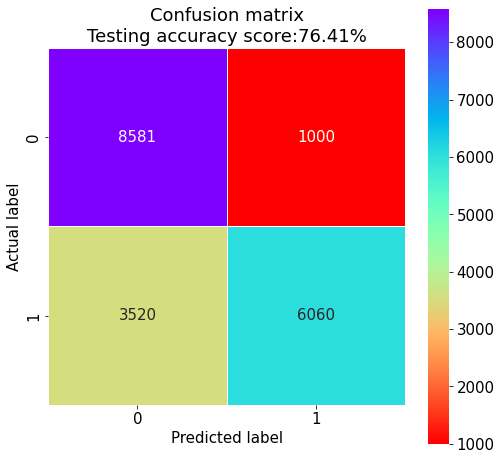

In [30]:
logit = LogisticRegression(penalty='l2',tol=0.0001,C=1,random_state=seed,
                           solver='liblinear',multi_class='ovr',max_iter=100,verbose=1)
logit.fit(std_X,std_y)
test_score = np.round(logit.score(std_X_test,std_y_test)*100,2)
print('='*80)
print(f"|+| test accuracy: \t{test_score}%")
print('='*80)
cm = metrics.confusion_matrix(std_y_test,logit.predict(std_X_test))
print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
print('='*80)
plt.rcParams.update({'font.size':15})
ax = plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nTesting accuracy score:{}%'.format(test_score),size=18)
plt.show()

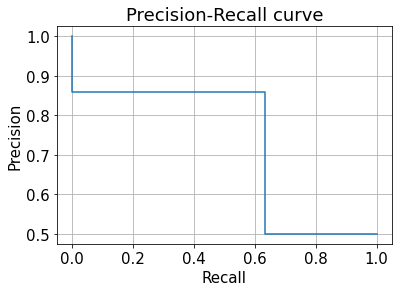

In [31]:
precision, recall, _ = metrics.precision_recall_curve(std_y_test,logit.predict(std_X_test))
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
disp.ax_.set(title="Precision-Recall curve")
disp.ax_.grid(True)
plt.show()

In [32]:
C = 1 # SVM regularization parameter
max_iter = 100000
svm_models = [svm.LinearSVC(C=C,max_iter=max_iter),
              svm.SVC(kernel='rbf',gamma='auto',max_iter=max_iter,C=C)]
svm_models = [clf.fit(std_X,std_y) for clf in svm_models]

||Linear SVC	testing score: 76.39
|+| test accuracy: 	76.39%
false negative rate: 37.4426%


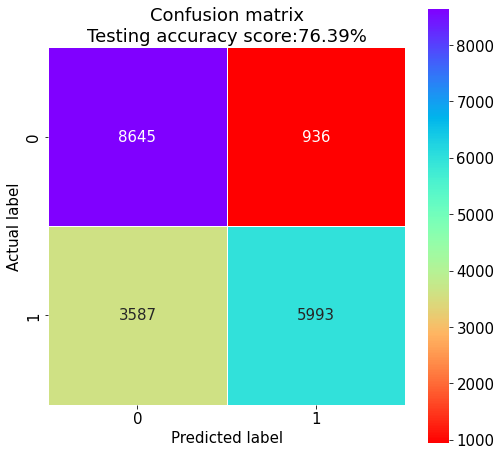

||SVC with RBF kernel	testing score: 83.65
|+| test accuracy: 	83.65%
false negative rate: 24.1232%


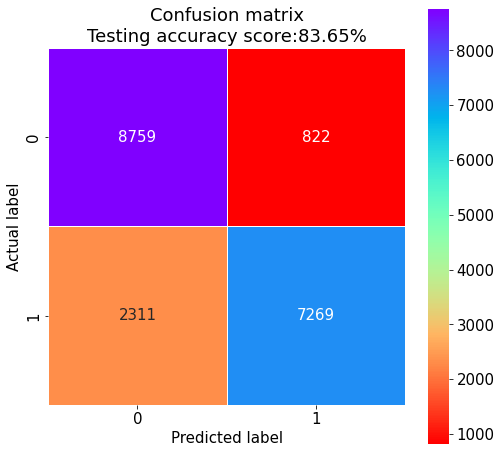

In [33]:
svm_titles = ['Linear SVC', 'SVC with RBF kernel']
for i, clf in enumerate(svm_models):
    test_score = np.round(clf.score(std_X_test,std_y_test)*100,2)
    print("="*80)
    print(f"||{svm_titles[i]}\ttesting score: {test_score}")
    print('='*80)
    print(f"|+| test accuracy: \t{test_score}%")
    print('='*80)
    cm = metrics.confusion_matrix(std_y_test,clf.predict(std_X_test))
    print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
    print('='*80)
    plt.rcParams.update({'font.size':15})
    ax = plt.figure(figsize=(8,8))
    sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix\nTesting accuracy score:{}%'.format(test_score),size=18)
    plt.show()

gini impurity max tree depth of 3 accuracy: 74.74%
false negative rate: 41.1378%


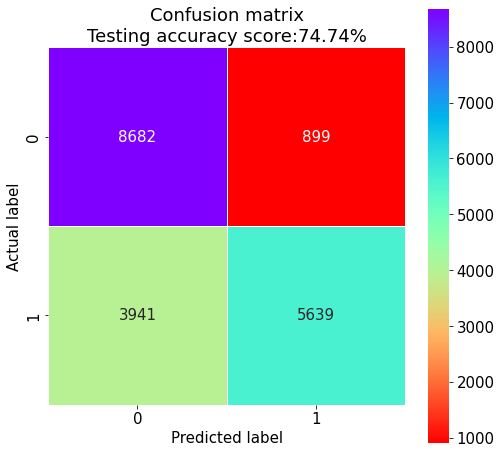

entropy impurity max tree depth of 3 accuracy: 74.49%
false negative rate: 18.9875%


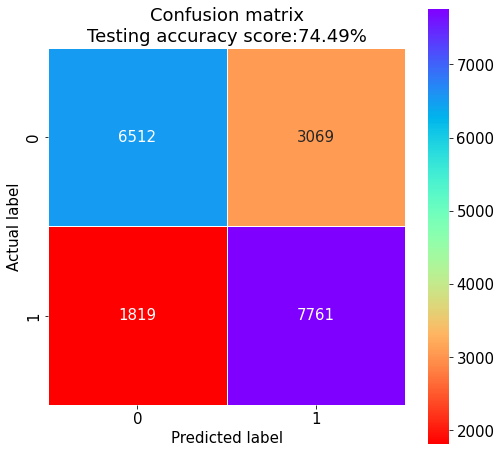

In [34]:
tree_models = []
accuracies = []
criterion = ['gini','entropy']
depth = 3
for j, c in enumerate(criterion):
    tree_models.append(DecisionTreeClassifier(criterion=c,max_depth=depth,random_state=seed))
    tree_models[j].fit(std_X,std_y)
    accuracies.append(np.round(tree_models[j].score(std_X_test,std_y_test)*100,2))
    print('='*80)
    print(f"{c} impurity max tree depth of {depth} accuracy: {accuracies[j]}%")
    print('='*80)
    cm = metrics.confusion_matrix(std_y_test,tree_models[j].predict(std_X_test))
    print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
    print('='*80)
    plt.rcParams.update({'font.size':15})
    ax = plt.figure(figsize=(8,8))
    sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix\nTesting accuracy score:{}%'.format(accuracies[j]),size=18)
    plt.show()

The highest accuracy with depth 3


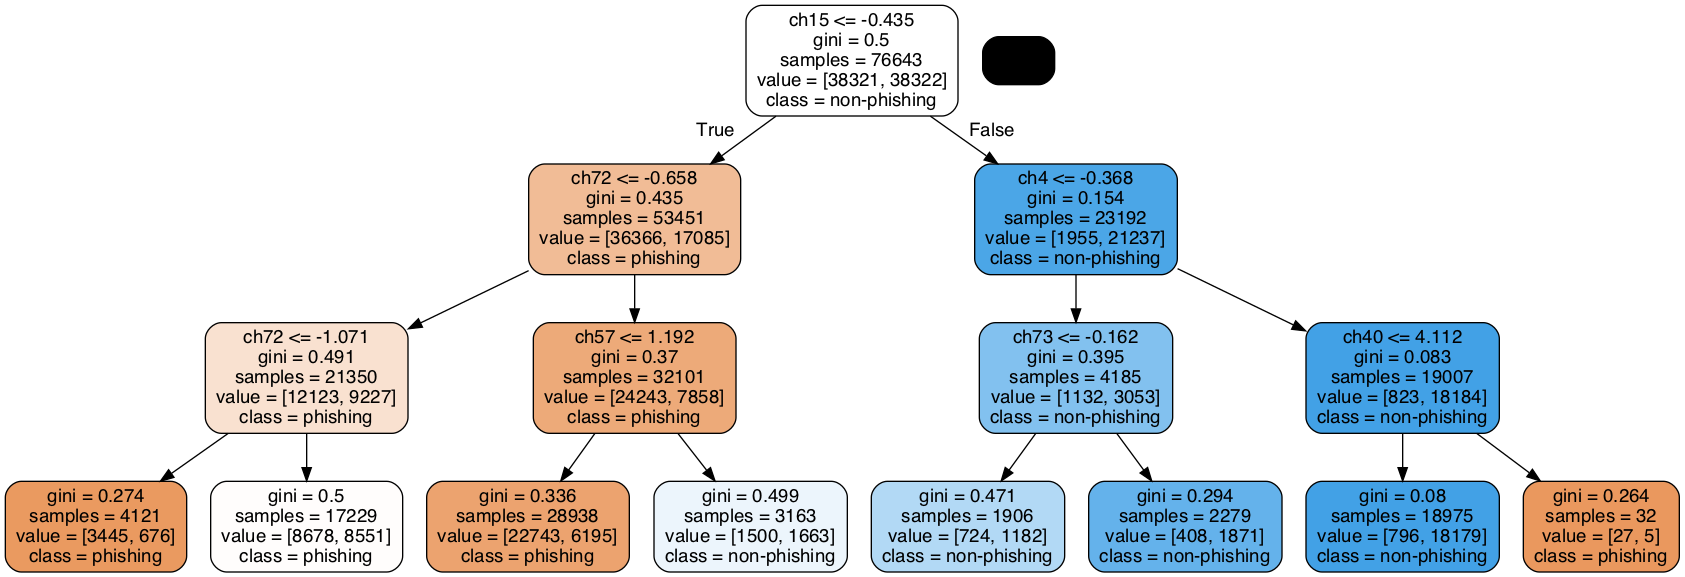

In [35]:
print(f"The highest accuracy with depth {depth}")
dot_data = export_graphviz(tree_models[0],filled=True,rounded=True,
                           class_names=['phishing','non-phishing'],
                           feature_names=[f'ch{i+1}' for i in range(std_X.shape[1])],out_file=None)
dot_graph = graph_from_dot_data(dot_data)
dot_graph.write_png('gini0.png')
Image('gini0.png',height=1000,width=1000)

gini impurity max tree depth of 6 accuracy: 82.63%
false negative rate: 20.4593%


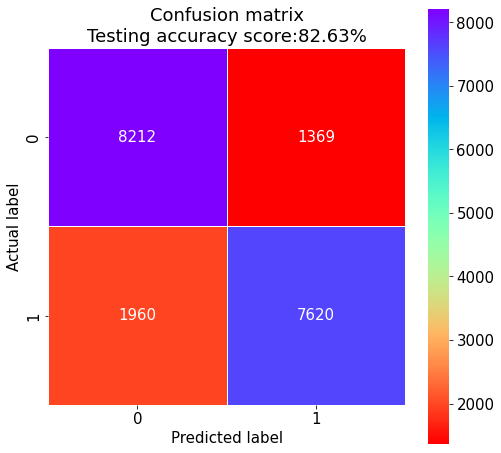

entropy impurity max tree depth of 6 accuracy: 81.64%
false negative rate: 25.1670%


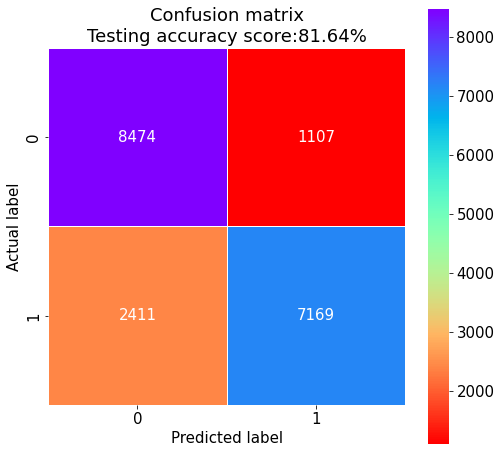

In [36]:
tree_models = []
accuracies = []
criterion = ['gini','entropy']
depth = 6
for j, c in enumerate(criterion):
    tree_models.append(DecisionTreeClassifier(criterion=c,max_depth=depth,random_state=seed))
    tree_models[j].fit(std_X,std_y)
    accuracies.append(np.round(tree_models[j].score(std_X_test,std_y_test)*100,2))
    print('='*80)
    print(f"{c} impurity max tree depth of {depth} accuracy: {accuracies[j]}%")
    print('='*80)
    cm = metrics.confusion_matrix(std_y_test,tree_models[j].predict(std_X_test))
    print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
    print('='*80)
    plt.rcParams.update({'font.size':15})
    ax = plt.figure(figsize=(8,8))
    sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix\nTesting accuracy score:{}%'.format(accuracies[j]),size=18)
    plt.show()

The highest accuracy with depth 6


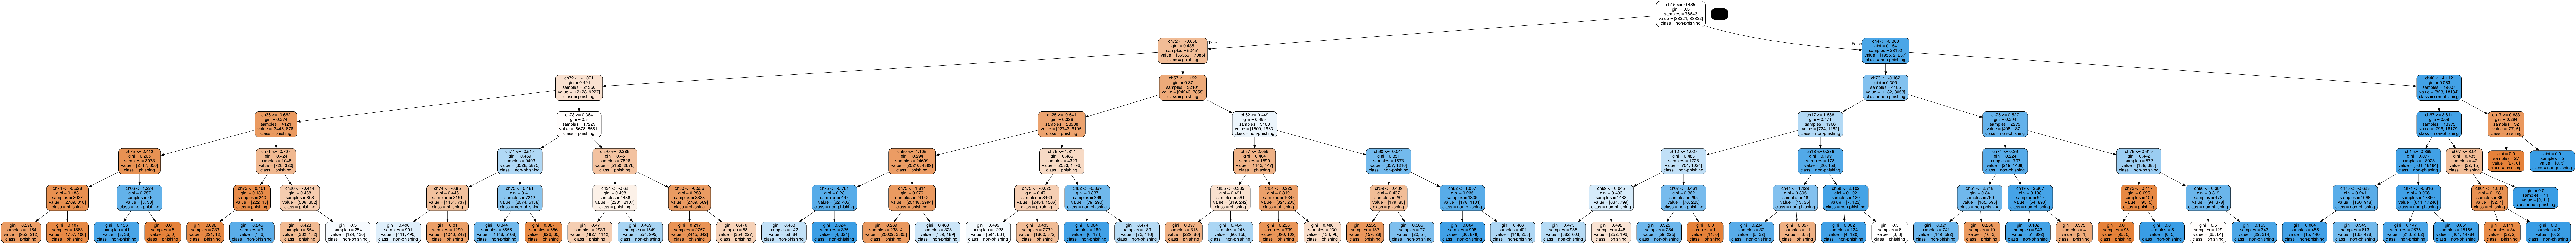

In [37]:
print(f"The highest accuracy with depth {depth}")
dot_data = export_graphviz(tree_models[0],filled=True,rounded=True,
                           class_names=['phishing','non-phishing'],
                           feature_names=[f'ch{i+1}' for i in range(std_X.shape[1])],out_file=None)
dot_graph = graph_from_dot_data(dot_data)
dot_graph.write_png('gini1.png')
Image('gini1.png',height=1000,width=1000)

Adaboost with decision tree base gini of depth 6 accuracy:92.54%
false negative rate: 8.4551%


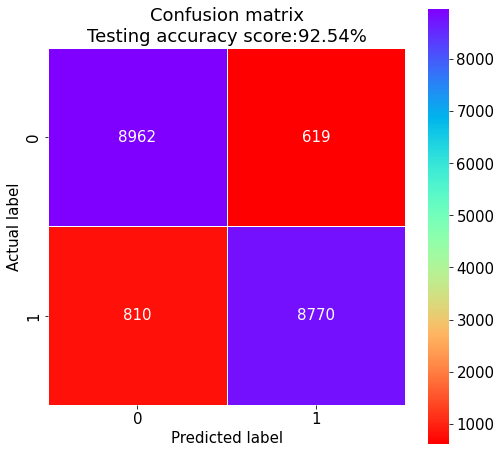

Adaboost with decision tree base entropy of depth 6 accuracy:92.6%
false negative rate: 8.4969%


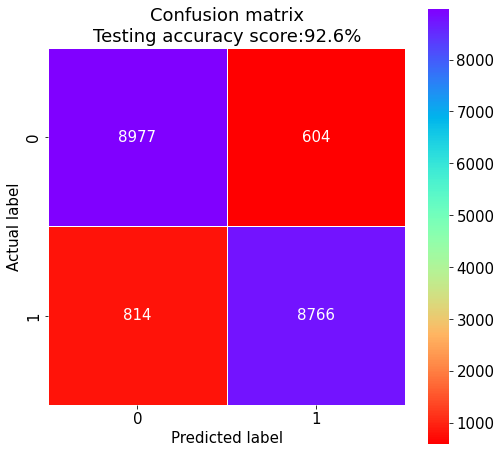

In [38]:
adas = []
for j in range(2):
    adas.append(AdaBoostClassifier(base_estimator=tree_models[j],n_estimators=500,
                                   learning_rate=0.1,random_state=seed))
    adas[j].fit(std_X,std_y)
    test_score = np.round(adas[j].score(std_X_test,std_y_test)*100,2)
    print("="*80)
    print(f"Adaboost with decision tree base {criterion[j]} of depth {depth} accuracy:"
          f"{test_score}%")
    print("="*80)
    cm = metrics.confusion_matrix(std_y_test,adas[j].predict(std_X_test))
    print("false negative rate: {:0.4f}%".format(false_negative_rate(cm)*100))
    print('='*80)
    plt.rcParams.update({'font.size':15})
    ax = plt.figure(figsize=(8,8))
    sns.heatmap(cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='rainbow_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix\nTesting accuracy score:{}%'.format(test_score),size=18)
    plt.show()